# Significant aspects of model construction

* adding in bubbles to each of the three model types explored in first verification
* testing out different scales of each

Metrics upon which to assess these:
* cases over time
* deaths over time
* effective R at different points
* constraint-specific measures (e.g. cases over time per district in models with districts)

## Section A. Define Functions needed 
### A1. First the model inputs and outputs to include:
- processModelOutput: decides the format of the files that will be output
- processInfections: the format of the infections file
- findROFInstance: total number of individuals infected by the introduction of an infected person (is this returned at the end of a model run?
- WorldBankMASONmodel: defines teh input directory for the parameters to be used, the format of the output files with the aggregate figures and the infections, and how we edit the parameters and includes the amount of memory used in the server to run the model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob
import subprocess
import re
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style="darkgrid")

In [2]:


def processModelOutput(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return {'results': r_data}

def processInfections(filename):
    r_data = pd.read_csv(filename, sep='\t')
    return {'results': r_data}
    

def findROFInstance():
    # total number of individuals infected by the introduction of an infectious person
    return beta * n

def WorldBankMASONmodel(myOutputPrefix, seed, paramfile, beta, numDays=90):
    
    dataDir = "/home/wb488473/Disease-Modelling-SSA/data/verification/"
    #"/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/"
    exportFilename = myOutputPrefix + "_agg_" + str(seed) + "_" + str(beta) + ".txt"
    exportInfectionsFilename = myOutputPrefix + "_Infections_" + str(seed) + "_" + str(beta) + ".txt"
    
    subprocess.call(['java', '-Xms20G', '-jar', '../java/WorldBankCovid19/libs/WB_covid19ABM.jar', str(numDays), 
                     dataDir, str(beta), str(seed), exportFilename, paramfile, exportInfectionsFilename])
    
    # Sophie upped the -Xms to 20G from 6GB
    #return processModelOutput(exportFilename)
    return processInfections(exportInfectionsFilename)

def processModelOutput(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return {'results': r_data}

def processInfections(filename):
    r_data = pd.read_csv(filename, sep='\t')
    return {'results': r_data}
    

def findROFInstance():
    # total number of individuals infected by the introduction of an infectious person
    return beta * n

def WorldBankMASONmodel(myOutputPrefix, seed, paramfile, beta, numDays=90):
    
    dataDir = "/home/wb488473/Disease-Modelling-SSA/data/verification/"
    #"/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/"
    exportFilename = myOutputPrefix + "_agg_" + str(seed) + "_" + str(beta) + ".txt"
    exportInfectionsFilename = myOutputPrefix + "_Infections_" + str(seed) + "_" + str(beta) + ".txt"
    
    subprocess.call(['java', '-Xms30G', '-jar', '../java/WorldBankCovid19/libs/WB_covid19ABM.jar', str(numDays), 
                     dataDir, str(beta), str(seed), exportFilename, paramfile, exportInfectionsFilename])
    
    # Sophie upped the -Xms to 20G from 6GB
    #return processModelOutput(exportFilename)
    return processInfections(exportInfectionsFilename)

In [3]:

def plotMetric(files, prefix, suffix, metrics = [], symbol = "-", alpha=1, weighting = 1):
    myAvgLine = []
    index = 0
    template = "^" + prefix + ".*" + suffix + "$"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data_raw = pd.read_csv(path + f, sep='\t')
            #we need to add an if statement here for only if it's a multidistrict model do we do this aggregation
            unique_dist_names = pd.unique(r_data_raw['myId'])
            if len(unique_dist_names) == 1:
                r_data = r_data_raw
            else:
                r_data = r_data_raw.groupby('time', as_index=False).agg({'metric_died_count': 'sum', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})
            totcases = []
            for metric in metrics:
                if len(totcases) == 0:
                    totcases = r_data[metric]
                else:        
                    totcases = totcases + r_data[metric]
            #totcases = r_data[metric]
            
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], weighting * totcases[1:], symbol, alpha=alpha)
            index += 1
    return {"myLine": weighting * myAvgLine/index, "myTime": r_data["time"]}

## Section B: Run the model scenarios
In this part we are able to use the functions defined above to run different versions of the model to create different outputs

### B4. Comparing different scales on perfect mixing - multi-district, multi-status model, without weekends

This notebook is a continuation of 'verification of model functionality' by first comparing different scales of the population being used with the decided model. 

### B4.1 Comparing to 5% sample

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist_noWknds_5perc.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(11,12):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_noWkends_5p_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B4.2 Comparing to 20% sample

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist_noWknds_20perc.txt"]   
betasPerScenario = [0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(6,12):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_noWkends_20p_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B4.3 Comparing to 50% sample

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist_noWknds_50perc.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(6,12):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_noWkends_50p_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B1.3 Comparing to 75% sample

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist_noWknds_75perc.txt"]   
betasPerScenario = [0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(6,12):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_noWkends_75p_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B1.4 Comparing to 100% sample

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist_noWknds_100perc.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(2,5):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_noWkends_100p_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

Now before running the next section, I transfer all the outputs to relevant folders within sweep because otherwise if we accidentally run the code again for producing new output, it will write to the same file and append, which can cause issues later on

## Section C: Plot the model results
In this section, we're able to plot different outputs on the same graph to compare (using the plotMetric function created in section A)

### C1.1 Plot B4.1 results - Multidist, multi status, no weekends, with 5% sample

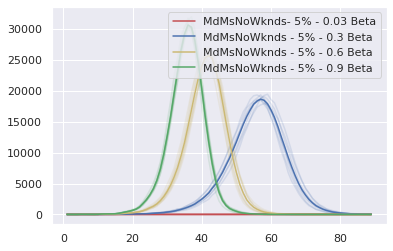

In [4]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidistmultistatus_no_wknds_5p/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_noWkends_5p_betaComparison__agg"

line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"],'r-', 0.15) #, weighting=4 
# weighting is for the purpose of comparing between diff census sizes i.e. it scales by x4 the results being plotted
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MdMsNoWknds- 5% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MdMsNoWknds - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MdMsNoWknds - 5% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MdMsNoWknds - 5% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.rcParams["figure.figsize"] = (15,5)
plt.savefig(path + "MDMSNoWknds_beta_comps_90days_5p.png", dpi=300)

### C1.2 Plot B4.2 results - 20% sample

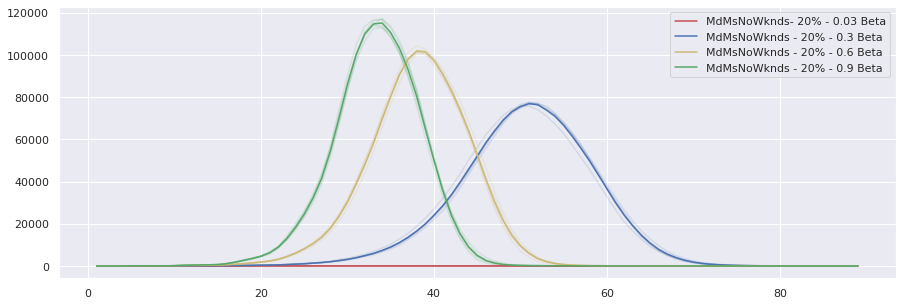

In [5]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidistmultistatus_no_wknds_20p/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_noWkends_20p_betaComparison__agg_"  


line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"],'r-', 0.15)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MdMsNoWknds- 20% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MdMsNoWknds - 20% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MdMsNoWknds - 20% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MdMsNoWknds - 20% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()
plt.rcParams["figure.figsize"] = (15,5)
plt.savefig(path + "MDMS_noWkends_beta_comps_90days_20p.png", dpi=300)

### C1.3 Plot B4.3 results - 50% sample

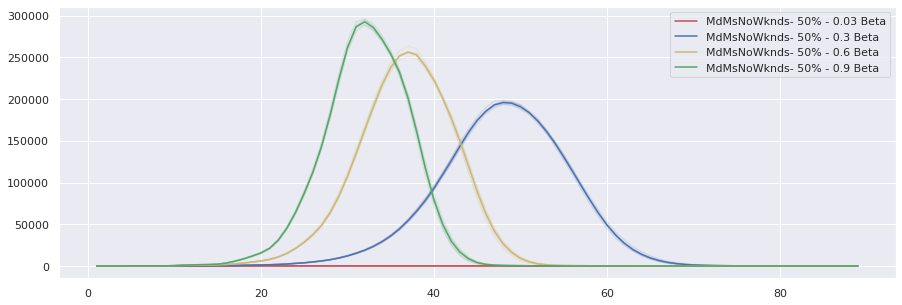

In [6]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidistmultistatus_no_wknds_50p/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_noWkends_50p_betaComparison__agg_"  


line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"],'r-', 0.15)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MdMsNoWknds- 50% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MdMsNoWknds- 50% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MdMsNoWknds- 50% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MdMsNoWknds- 50% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()
plt.rcParams["figure.figsize"] = (15,5)

plt.savefig(path + "MDMS_noWkends_beta_comps_90days_50p.png", dpi=300)

### C1.4 Plot B4.4 results - 75% sample

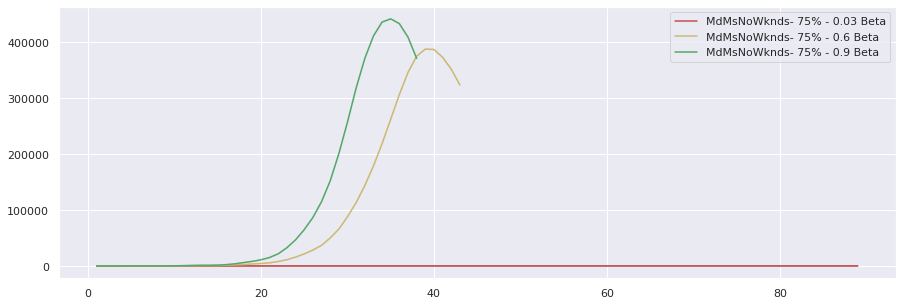

In [7]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidistmultistatus_no_wknds_75p/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_noWkends_75p_betaComparison__agg_"  


line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"],'r-', 0.15)
#line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MdMsNoWknds- 75% - 0.03 Beta")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MdMsNoWknds- 75% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MdMsNoWknds- 75% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MdMsNoWknds- 75% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()
plt.rcParams["figure.figsize"] = (15,5)

plt.savefig(path + "MDMS_noWkends_beta_comps_90days_75p.png", dpi=300)

### C1.5 Plot B4.5 results - 100% sample

In [8]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidistmultistatus_no_wknds_100p/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/multidist_multistatus/"


files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_noWkends_100p_betaComparison__agg_"

line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"], 'r-', 0.15)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MDistMStat- 5% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MDistMStat - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MDistMStat - 5% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MDistMStat - 5% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "MDMS_nowknds_beta_comps_90days_100p.png", dpi=300)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

### C4. Now choose one beta and compare across sample sizes

### 4.1 without scaling

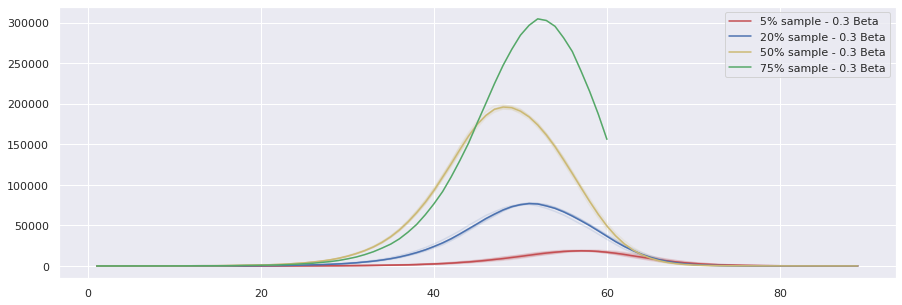

In [9]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/compare_scale/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/compare/"

files = os.listdir(path)

prefix  = "sweep_multiStatusMultiDist_noWkends_5p_betaComparison__agg_"
prefix2 = "sweep_multiStatusMultiDist_noWkends_20p_betaComparison__agg_"
prefix3 = "sweep_multiStatusMultiDist_noWkends_50p_betaComparison__agg_"
prefix4 = "sweep_multiStatusMultiDist_noWkends_75p_betaComparison__agg_"

line1 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'r-', 0.15)
line2 = plotMetric(files, prefix2, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix3, "0.3.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix4, "0.3.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="5% sample - 0.3 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="20% sample - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="50% sample - 0.3 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="75% sample - 0.3 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "comp_MSMDS_scales_p3beta_noWknds.png", dpi=300)



### 4.2 with scaling

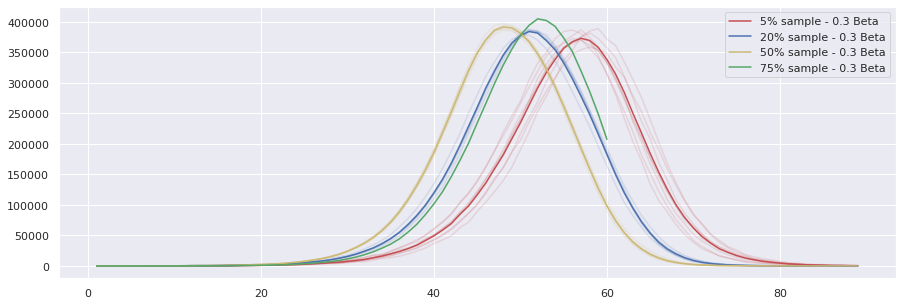

In [10]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/compare_scale/"
#path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/compare/"

files = os.listdir(path)

prefix  = "sweep_multiStatusMultiDist_noWkends_5p_betaComparison__agg_"
prefix2 = "sweep_multiStatusMultiDist_noWkends_20p_betaComparison__agg_"
prefix3 = "sweep_multiStatusMultiDist_noWkends_50p_betaComparison__agg_"
prefix4 = "sweep_multiStatusMultiDist_noWkends_75p_betaComparison__agg_"

line1 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'r-', 0.15, weighting=20)
line2 = plotMetric(files, prefix2, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15, weighting=5)
line3 = plotMetric(files, prefix3, "0.3.txt", ["metric_new_cases_sympt"], 'y-', 0.15, weighting=2)
line4 = plotMetric(files, prefix4, "0.3.txt", ["metric_new_cases_sympt"], 'g-', 0.15, weighting=1.33)
#line4 = plotMetric(files, prefix5, "0.3.txt", ["metric_new_cases_sympt"], 'g-', 0.15, weighting=1.33)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="5% sample - 0.3 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="20% sample - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="50% sample - 0.3 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="75% sample - 0.3 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="100% sample - 0.3 Beta")


plt.legend()

plt.savefig(path + "comp_MSMDS_scales_p3beta_noWknds_weighted.png", dpi=300)
